In [1]:
import shutil
# loading data into python structures
try:
    shutil.rmtree(".data/dnd-cnn-split/train")
    shutil.rmtree("data/dnd-cnn-split/test")
except:
    pass

In [2]:
import os
# ensure directories exist
from pathlib import Path

Path("data/dnd-cnn-split/train/damage").mkdir(parents=True, exist_ok=True)
Path("data/dnd-cnn-split/train/no-damage").mkdir(parents=True, exist_ok=True)

Path("data/dnd-cnn-split/test/damage").mkdir(parents=True, exist_ok=True)
Path("data/dnd-cnn-split/test/no-damage").mkdir(parents=True, exist_ok=True)


In [3]:
all_damage_file_paths = os.listdir('dataset/Project3/damage')
all_no_damage_file_paths = os.listdir('dataset/Project3/no_damage')

In [4]:
import random

train_damage_paths = random.sample(all_damage_file_paths, int(len(all_damage_file_paths)*0.8))
print("train damage image count: ", len(train_damage_paths))
test_damage_paths = [ p for p in all_damage_file_paths if p not in train_damage_paths]
print("test damage image count: ", len(test_damage_paths))
# ensure no overlap:
overlap = [p for p in train_damage_paths if p in test_damage_paths]
print("len of overlap: ", len(overlap))


train_no_damage_paths = random.sample(all_no_damage_file_paths, int(len(all_no_damage_file_paths)*0.8))
print("train no damage image count: ", len(train_no_damage_paths))
test_no_damage_paths = [ p for p in all_no_damage_file_paths if p not in train_no_damage_paths]
print("test no damage image count: ", len(test_no_damage_paths))
# ensure no overlap:
overlap = [p for p in train_no_damage_paths if p in test_no_damage_paths]
print("len of overlap: ", len(overlap))


train damage image count:  11336
test damage image count:  2834
len of overlap:  0
train no damage image count:  5721
test no damage image count:  1431
len of overlap:  0


In [5]:
# ensure to copy the images to the directories
import shutil
for p in train_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/damage', p), os.path.join('data/dnd-cnn-split/train/damage', p) )

for p in test_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/damage', p), os.path.join('data/dnd-cnn-split/test/damage', p) )

for p in train_no_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/no_damage', p), os.path.join('data/dnd-cnn-split/train/no-damage', p) )

for p in test_no_damage_paths:
    shutil.copyfile(os.path.join('dataset/Project3/no_damage', p), os.path.join('data/dnd-cnn-split/test/no-damage', p) )



# check counts:
print("Files in train/damage: ", len(os.listdir("data/dnd-cnn-split/train/damage")))
print("Files in train/no-damage: ", len(os.listdir("data/dnd-cnn-split/train/no-damage")))

print("Files in test/damage: ", len(os.listdir("data/dnd-cnn-split/test/damage")))
print("Files in test/no-damage: ", len(os.listdir("data/dnd-cnn-split/test/no-damage")))

# shape of damage and no damage training/testing files


Files in train/damage:  13625
Files in train/no-damage:  6850
Files in test/damage:  5123
Files in test/no-damage:  2560


In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# path to training data
train_data_dir = 'data/dnd-cnn-split/train'

# controls the size of the "batches" of images streamed when accessing the datasets.
# this is useful to control the memory usage with very large datasets
batch_size = 32

# target image size
img_height = 150
img_width = 150

# note that the subset parameter can take values of "training", "validation", or "both";
# the value dictates which dataset is returned (we want both)
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
# rescale instance
rescale = Rescaling(scale=1.0/255)

# apply the rescale to the train and validation sets
train_rescale_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_rescale_ds = val_ds.map(lambda image,label:(rescale(image),label))


2025-04-08 06:19:39.300576: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 06:19:39.339799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 06:19:39.339852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:19:39.341209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 06:19:39.348044: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 06:19:39.348866: I tensorflow/core/platform/cpu_feature_guard.cc:1

Found 20475 files belonging to 2 classes.
Using 16380 files for training.
Using 4095 files for validation.


In [7]:
# path to test data
test_data_dir = 'data/dnd-cnn-split/test/'

# we do not set subset=both here because we do not want the test set split
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
)

# approach 1: manually rescale data --
rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image,label:(rescale(image),label))

Found 7683 files belonging to 2 classes.


In [8]:
for images, labels in train_ds.take(1):  # Take one batch
    print("Train batch shape:", images.shape)  # Shape: (batch_size, height, width, channels)
    print("Train labels shape:", labels.shape)  # Shape: (batch_size,)


Train batch shape: (32, 150, 150, 3)
Train labels shape: (32,)


In [9]:
for images, labels in test_ds.take(1):
    print("Test batch shape:", images.shape)
    print("Test labels shape:", labels.shape)


Test batch shape: (32, 150, 150, 3)
Test labels shape: (32,)


Label for each of the above images: [0 0 0 0 0]


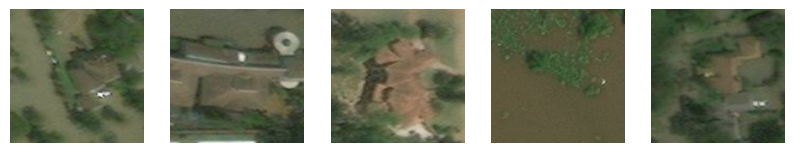

In [10]:
import matplotlib.pyplot as plt

# Get one batch of images and labels from the rescaled dataset
for images, labels in train_rescale_ds.take(1):  
    X_train_batch = images.numpy()  # Convert to NumPy array
    y_train_batch = labels.numpy()  # Convert labels to NumPy
    break

# Plot the first 5 images
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_batch[i])  # No need for uint8 conversion since values are [0,1]
    plt.axis("off")

print('Label for each of the above images:', y_train_batch[:5])


In [11]:
# # creating ANN model
# def create_perceptron(dim):
#     """
#     Create a perceptron of dimension `dim` and initialize it with random weights.
#     """
#     # we use dim+1 because we want to have a bias term and `dim` weights
#     return np.random.random(dim+1)

In [12]:
# def create_layer(num_perceptrons, dim, activation_function):
#     """
#     Create a layer of `num_perceptrons` perceptron, each of dimension `dim` with activation function `activation_function`.
#     Initialize the weights of all perceptrons to a random float between 0 and 1.
#     """
#     # represent the layer as a list of dictionary of perceptrons
#     layer = []
#     for i in range(num_perceptrons):
#         layer.append({"weights": create_perceptron(dim), "activation_function": activation_function})
#     return layer

In [13]:
# try different layers and perceptrons to choose the best combination for accuracy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(128, activation='relu'),  # Hidden layer with ReLU
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8640257 (32.96 MB)
Trainable params: 8640257 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Train the model
history = model.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=15,  # Can be adjusted
    batch_size=32,
    verbose=1
)


Epoch 1/15
512/512 [==============================] - 28s 53ms/step - loss: 0.9363 - accuracy: 0.6676 - val_loss: 0.6843 - val_accuracy: 0.6806
Epoch 2/15
512/512 [==============================] - 29s 57ms/step - loss: 0.6077 - accuracy: 0.7037 - val_loss: 0.6986 - val_accuracy: 0.6830
Epoch 3/15
512/512 [==============================] - 30s 59ms/step - loss: 0.6027 - accuracy: 0.7102 - val_loss: 0.5957 - val_accuracy: 0.6823
Epoch 4/15
512/512 [==============================] - 31s 60ms/step - loss: 0.5788 - accuracy: 0.7219 - val_loss: 0.6216 - val_accuracy: 0.6488
Epoch 5/15
512/512 [==============================] - 30s 59ms/step - loss: 0.5537 - accuracy: 0.7345 - val_loss: 0.6462 - val_accuracy: 0.6225
Epoch 6/15
512/512 [==============================] - 27s 53ms/step - loss: 0.5394 - accuracy: 0.7451 - val_loss: 0.5754 - val_accuracy: 0.7233
Epoch 7/15
512/512 [==============================] - 27s 52ms/step - loss: 0.5427 - accuracy: 0.7439 - val_loss: 0.6762 - val_accuracy:

In [15]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_rescale_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


241/241 [==============================] - 2s 6ms/step - loss: 0.5683 - accuracy: 0.6668
Test Loss: 0.5683
Test Accuracy: 0.6668


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the model
model2 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(512, activation='relu'),  # Hidden layer with ReLU
    Dense(256, activation='relu'),   # Another hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model2.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 67500)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               34560512  
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34692097 (132.34 MB)
Trainable params: 34692097 (132.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Train the model
history = model2.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=15,  # Can be adjusted
    batch_size=32,
    verbose=1
)


Epoch 1/15
512/512 [==============================] - 104s 202ms/step - loss: 1.1260 - accuracy: 0.6529 - val_loss: 0.5738 - val_accuracy: 0.7101
Epoch 2/15
512/512 [==============================] - 102s 198ms/step - loss: 0.5796 - accuracy: 0.7122 - val_loss: 0.5667 - val_accuracy: 0.7228
Epoch 3/15
512/512 [==============================] - 102s 198ms/step - loss: 0.5585 - accuracy: 0.7281 - val_loss: 0.5485 - val_accuracy: 0.7436
Epoch 4/15
512/512 [==============================] - 105s 204ms/step - loss: 0.6218 - accuracy: 0.6696 - val_loss: 0.6456 - val_accuracy: 0.6523
Epoch 5/15
512/512 [==============================] - 101s 198ms/step - loss: 0.6034 - accuracy: 0.6687 - val_loss: 0.6094 - val_accuracy: 0.6523
Epoch 6/15
512/512 [==============================] - 102s 199ms/step - loss: 0.6182 - accuracy: 0.6687 - val_loss: 0.6075 - val_accuracy: 0.6523
Epoch 7/15
512/512 [==============================] - 102s 199ms/step - loss: 0.5916 - accuracy: 0.6659 - val_loss: 0.6717 -

In [18]:
# Evaluate on test set
test_loss, test_acc = model2.evaluate(test_rescale_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


241/241 [==============================] - 3s 14ms/step - loss: 0.5496 - accuracy: 0.7528
Test Loss: 0.5496
Test Accuracy: 0.7528


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Define the model
model3 = Sequential([
    Flatten(input_shape=(150, 150, 3)),  # Flatten the image (150x150 RGB)
    Dense(512, activation='relu'),  # Hidden layer with ReLU
    Dense(256, activation='relu'),   # Another hidden layer
    Dense(128, activation='relu'),   # Another hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model3.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])

# Print model summary
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 67500)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               34560512  
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34724865 (132.46 MB)
Trainable params: 34724865 (132.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Train the model
history = model3.fit(
    train_rescale_ds,
    validation_data=val_rescale_ds,
    epochs=15,  # Can be adjusted
    batch_size=32,
    verbose=1
)


Epoch 1/15
512/512 [==============================] - 105s 203ms/step - loss: 1.0213 - accuracy: 0.6596 - val_loss: 0.6484 - val_accuracy: 0.6757
Epoch 2/15
512/512 [==============================] - 105s 204ms/step - loss: 0.5890 - accuracy: 0.7020 - val_loss: 0.5874 - val_accuracy: 0.6904
Epoch 3/15
512/512 [==============================] - 106s 207ms/step - loss: 0.5895 - accuracy: 0.7013 - val_loss: 0.6461 - val_accuracy: 0.6523
Epoch 4/15
512/512 [==============================] - 106s 207ms/step - loss: 0.6353 - accuracy: 0.6687 - val_loss: 0.6466 - val_accuracy: 0.6523
Epoch 5/15
512/512 [==============================] - 105s 205ms/step - loss: 0.6354 - accuracy: 0.6686 - val_loss: 0.6470 - val_accuracy: 0.6523
Epoch 6/15
512/512 [==============================] - 105s 204ms/step - loss: 0.6352 - accuracy: 0.6687 - val_loss: 0.6469 - val_accuracy: 0.6523
Epoch 7/15
512/512 [==============================] - 105s 205ms/step - loss: 0.6352 - accuracy: 0.6687 - val_loss: 0.6468 -

In [21]:
# Evaluate on test set
test_loss, test_acc = model3.evaluate(test_rescale_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

241/241 [==============================] - 3s 14ms/step - loss: 0.6365 - accuracy: 0.6668
Test Loss: 0.6365
Test Accuracy: 0.6668
